In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.rc('font',family='AppleGothic')
import warnings
warnings.filterwarnings(action='ignore')

df_raw=pd.read_csv('../data/raw_data/train.csv')
df=df_raw.copy()

sample_submission_raw=pd.read_csv('../data/raw_data/sample_submission.csv')
sample_submission=sample_submission_raw.copy()

In [21]:
df['일시']=pd.to_datetime(df['일시'],format="%Y%m%d")
df.set_index('일시',inplace=True)

df['일'] = df.index.day
df['월'] = df.index.month
df['년'] = df.index.year

df['요일']=df.index.day_of_week
df['주말평일'] = df['요일'].apply(lambda x: '평일' if x < 5 else '주말')
# --

sample_submission['일시']=pd.to_datetime(sample_submission['일시'],format="%Y%m%d")
sample_submission.set_index('일시',inplace=True)

sample_submission['일'] = sample_submission.index.day
sample_submission['월'] = sample_submission.index.month
sample_submission['년'] = sample_submission.index.year

sample_submission['요일']=sample_submission.index.day_of_week
sample_submission['주말평일'] = sample_submission['요일'].apply(lambda x: '평일' if x < 5 else '주말')

In [22]:
from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

In [23]:
df.loc[get_holiday(2018),'주말평일'] = '주말'
df.loc[get_holiday(2019),'주말평일'] = '주말'
df.loc[get_holiday(2020),'주말평일'] = '주말'
df.loc[get_holiday(2021),'주말평일'] = '주말'
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [24]:
df.drop(df[df['월']==12].index,inplace=True)

In [25]:
from sklearn.preprocessing import LabelEncoder,RobustScaler
lbe = LabelEncoder()
rbs = RobustScaler()
df['주말평일'] = lbe.fit_transform(df['주말평일'])
sample_submission['주말평일'] = lbe.transform(sample_submission['주말평일'])

df_3 = df.copy()
sample_submission_3 = sample_submission.copy()

df=pd.concat([df.drop(['월','요일'],axis=1),
                      pd.get_dummies(df['월']),
                      pd.get_dummies(df['요일'])],axis=1)

sample_submission=pd.concat([sample_submission.drop(['월','요일'],axis=1),
                     pd.get_dummies(sample_submission['월']),
                     pd.get_dummies(sample_submission['요일'])],axis=1)

In [26]:
df_2018_raw = df[df.index.year == 2018]
df_2019_raw = df[df.index.year == 2019]
df_2020_raw = df[df.index.year == 2020]
df_2021_raw = df[df.index.year == 2021]

In [27]:
# 1 
train_data_1 = df.copy()
test_data_1 = sample_submission.copy()

In [28]:
# 2
import numpy as np 

train_data_2 = df.copy()
test_data_2 = sample_submission.copy()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

df_2018 = train_data_2[train_data_2.index.year == 2018]
df_2019 = train_data_2[train_data_2.index.year == 2019]
df_2020 = train_data_2[train_data_2.index.year == 2020]
df_2021 = train_data_2[train_data_2.index.year == 2021]

for col in df_2018.columns[:4]:
    df_2018[col][15:-15] = smooth(df_2018[col],7)[15:-15]
for col in df_2019.columns[:4]:
    df_2019[col][15:-15] = smooth(df_2019[col],7)[15:-15]
for col in df_2020.columns[:4]:
    df_2020[col][15:-15] = smooth(df_2020[col],7)[15:-15]
for col in df_2021.columns[:4]:
    df_2021[col][15:-15] = smooth(df_2021[col],7)[15:-15]

train_data_2=pd.concat([df_2018,df_2019,df_2020,df_2021])

In [30]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

train_data_2_mms =mms.fit_transform(train_data_2.iloc[:,4:])
test_data_2_mms = mms.transform(test_data_2.iloc[:,4:])
train_target2 = train_data_2.iloc[:,:4]

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
kernel_ridge=KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# gradient_boosting=GradientBoostingRegressor()

gradient_boosting = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


vot_model3 = VotingRegressor(
    [('m1',kernel_ridge),
     ('m2',model_xgb),
     ('m3',model_lgb),
     ('m4',gradient_boosting)]    
)

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=3)
for i in range(4):
    print(f"{train_target2.columns[i]}")
    for model in [kernel_ridge, gradient_boosting, model_xgb, model_lgb,vot_model3]:
        result=cross_val_score(model,train_data_2_mms,train_target2.iloc[:,i],scoring='neg_mean_absolute_error')
        print(str(model).split('(')[0])
        print(np.mean(result)*-1)
    print('--'*10)

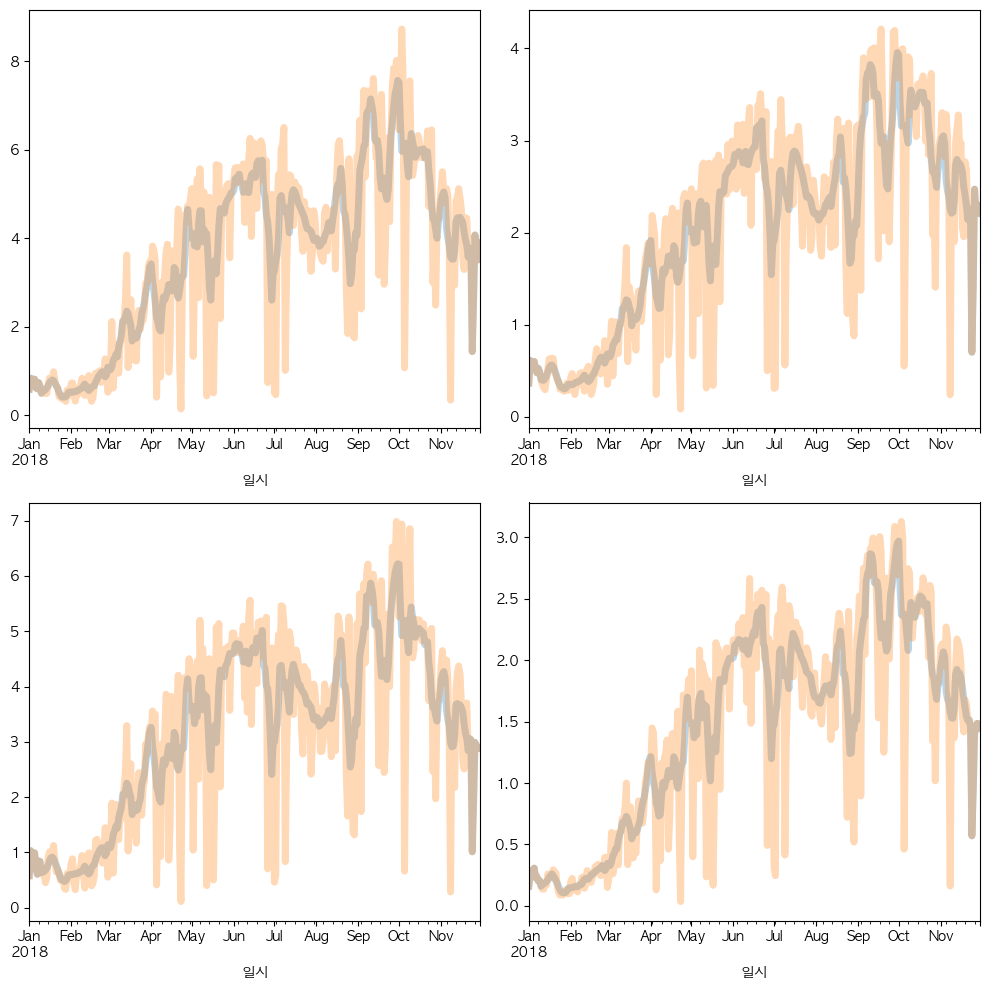

In [34]:
vot_model1 = VotingRegressor(
    [('m1',kernel_ridge),
     ('m2',model_xgb),
     ('m3',model_lgb),
     ('m4',gradient_boosting)]    
)
vot_model2 = VotingRegressor(
    [('m1',kernel_ridge),
     ('m2',model_xgb),
     ('m3',model_lgb),
     ('m4',gradient_boosting)]
)
vot_model3 = VotingRegressor(
    [('m1',kernel_ridge),
     ('m2',model_xgb),
     ('m3',model_lgb),
     ('m4',gradient_boosting)]    
)
vot_model4 = VotingRegressor(
    [('m1',kernel_ridge),
     ('m2',model_xgb),
     ('m3',model_lgb),
     ('m4',gradient_boosting)]    
)

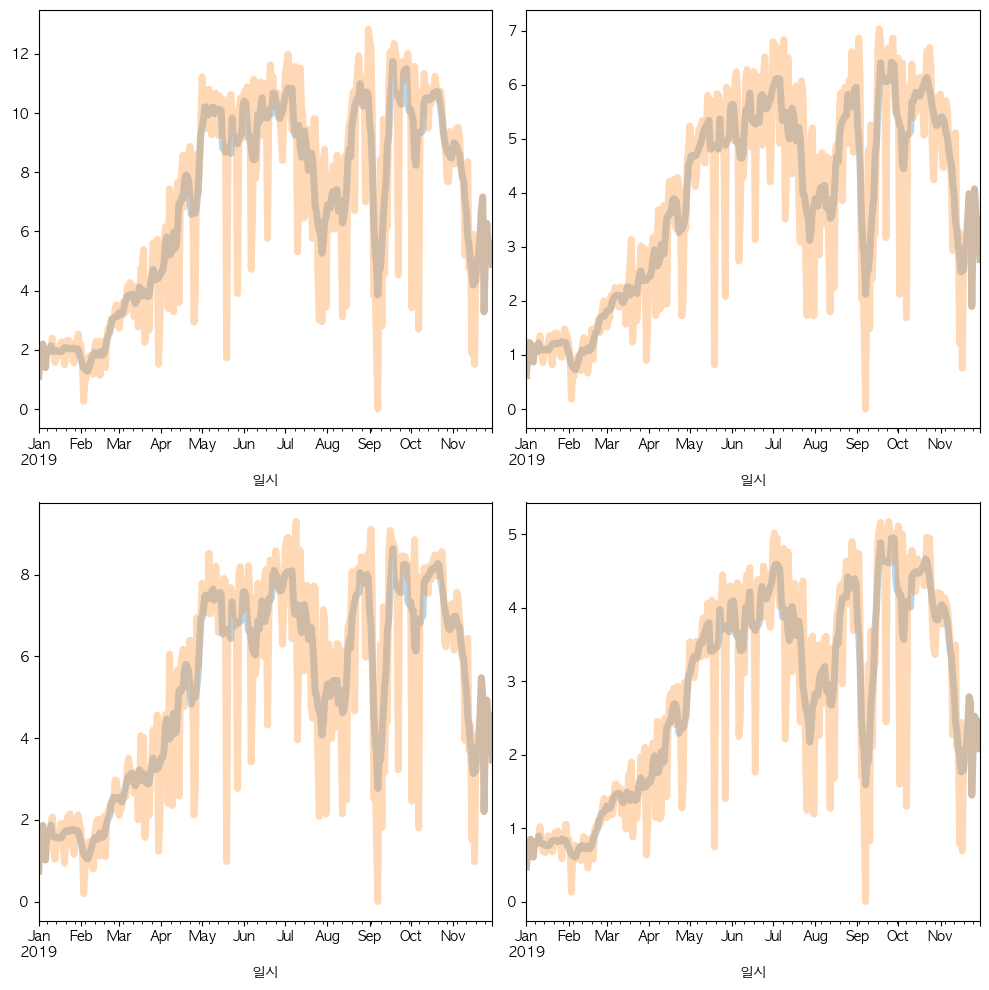

In [35]:
train_target_a = train_target2.iloc[:,0]
train_target_b = train_target2.iloc[:,1]
train_target_c = train_target2.iloc[:,2]
train_target_d = train_target2.iloc[:,3]

vot_model1.fit(train_data_2_mms,train_target_a)
vot_model2.fit(train_data_2_mms,train_target_b)
vot_model3.fit(train_data_2_mms,train_target_c)
vot_model4.fit(train_data_2_mms,train_target_d)

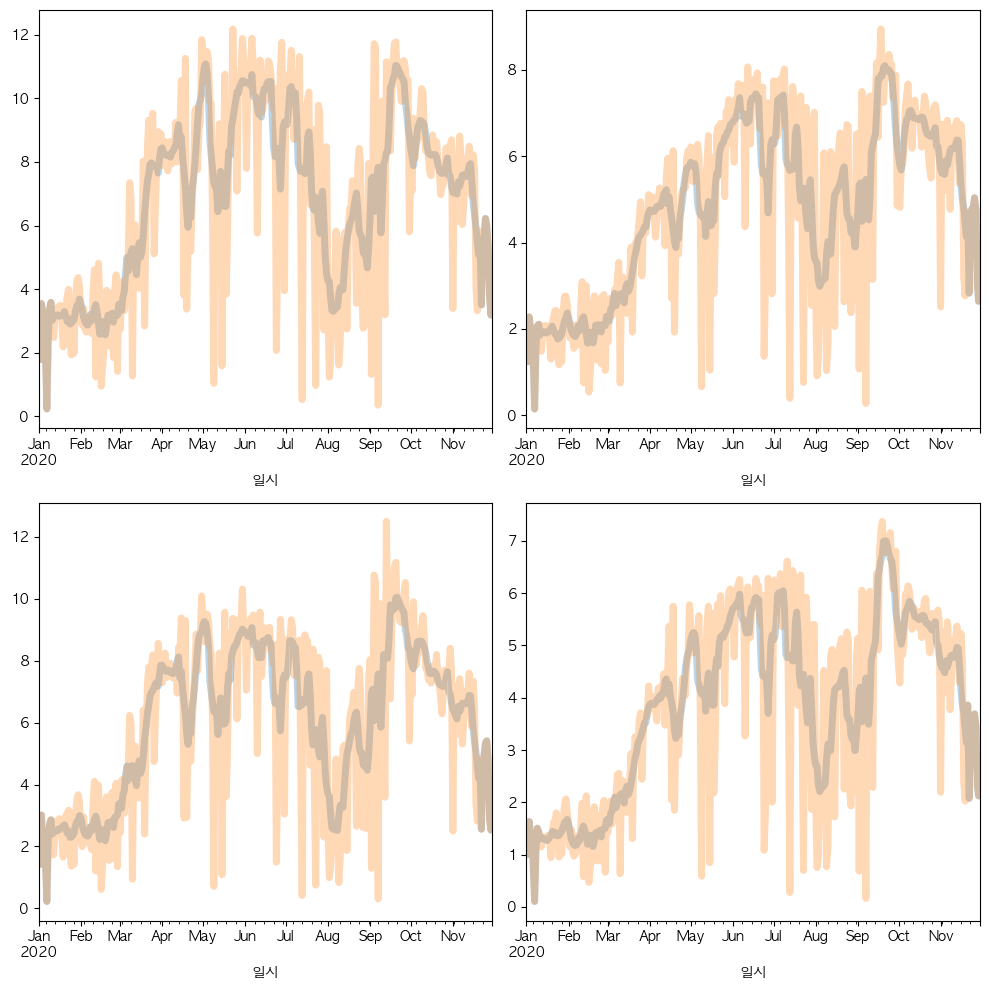

In [36]:
train_target_a = train_target2.iloc[:,0]
train_target_b = train_target2.iloc[:,1]
train_target_c = train_target2.iloc[:,2]
train_target_d = train_target2.iloc[:,3]

vot_model1.fit(train_data_2_mms,train_target_a)
vot_model2.fit(train_data_2_mms,train_target_b)
vot_model3.fit(train_data_2_mms,train_target_c)
vot_model4.fit(train_data_2_mms,train_target_d)

sample_submission_raw1=pd.read_csv('./../data/raw_data/sample_submission.csv')

sample_submission_raw1.iloc[:,1] =vot_model1.predict(test_data_2_mms)
sample_submission_raw1.iloc[:,2] =vot_model2.predict(test_data_2_mms)
sample_submission_raw1.iloc[:,3] =vot_model3.predict(test_data_2_mms)
sample_submission_raw1.iloc[:,4] =vot_model4.predict(test_data_2_mms)
sample_submission_raw1.iloc[:,1:].plot()

In [38]:
# 3
train_data_3 = df_3.copy()
test_data_3 = sample_submission_3.copy()

df_2018 = train_data_3[train_data_3.index.year == 2018]
df_2019 = train_data_3[train_data_3.index.year == 2019]
df_2020 = train_data_3[train_data_3.index.year == 2020]
df_2021 = train_data_3[train_data_3.index.year == 2021]

for months,rain in zip([[3,4,5],[6,7,8],[9,10,11]],[31,34,23]):
    temp=df_2018[df_2018['월'].isin(months)]
    for location in ['광진구','동대문구','성동구','중랑구']:
        temp.loc[temp[temp['월'].isin(months)][location].nsmallest(rain).index,location] = np.NaN
        temp[location]=temp[location].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
    df_2018[df_2018['월'].isin(months)] = temp

for months,rain in zip([[3,4,5],[6,7,8],[9,10,11]],[17,39,23]):
    temp=df_2019[df_2019['월'].isin(months)]
    for location in ['광진구','동대문구','성동구','중랑구']:
        temp.loc[temp[temp['월'].isin(months)][location].nsmallest(rain).index,location] = np.NaN
        temp[location]=temp[location].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
    df_2019[df_2019['월'].isin(months)] = temp

for months,rain in zip([[3,4,5],[6,7,8],[9,10,11]],[20,46,20]):
    temp=df_2020[df_2020['월'].isin(months)]
    for location in ['광진구','동대문구','성동구','중랑구']:
        temp.loc[temp[temp['월'].isin(months)][location].nsmallest(rain).index,location] = np.NaN
        temp[location]=temp[location].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
    df_2020[df_2020['월'].isin(months)] = temp

for months,rain in zip([[3,4,5],[6,7,8],[9,10,11]],[35,34,25]):
    temp=df_2021[df_2021['월'].isin(months)]
    for location in ['광진구','동대문구','성동구','중랑구']:
        temp.loc[temp[temp['월'].isin(months)][location].nsmallest(rain).index,location] = np.NaN
        temp[location]=temp[location].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
    df_2021[df_2021['월'].isin(months)] = temp

train_data_3[train_data_3.index.year == 2018] = df_2018
train_data_3[train_data_3.index.year == 2019] = df_2019
train_data_3[train_data_3.index.year == 2020] = df_2020
train_data_3[train_data_3.index.year == 2021] = df_2021

In [39]:
train_data_3.iloc[:,:4].mean()/df_raw.iloc[:,1:].mean()

광진구     1.170073
동대문구    1.158606
성동구     1.181362
중랑구     1.166801
dtype: float64

In [40]:
_2018_345=train_data_3[(train_data_3['년']==2018) & (train_data_3['월'].isin([3,4,5]))].iloc[:,:4].mean()/df_3[(df_3['년']==2018) & (df_3['월'].isin([3,4,5]))].iloc[:,:4].mean()
_2018_678=train_data_3[(train_data_3['년']==2018) & (train_data_3['월'].isin([6,7,8]))].iloc[:,:4].mean()/df_3[(df_3['년']==2018) & (df_3['월'].isin([6,7,8]))].iloc[:,:4].mean()
_2018_91011=train_data_3[(train_data_3['년']==2018) & (train_data_3['월'].isin([9,10,11]))].iloc[:,:4].mean()/df_3[(df_3['년']==2018) & (df_3['월'].isin([9,10,11]))].iloc[:,:4].mean()

_2019_345=train_data_3[(train_data_3['년']==2019) & (train_data_3['월'].isin([3,4,5]))].iloc[:,:4].mean()/df_3[(df_3['년']==2019) & (df_3['월'].isin([3,4,5]))].iloc[:,:4].mean()
_2019_678=train_data_3[(train_data_3['년']==2019) & (train_data_3['월'].isin([6,7,8]))].iloc[:,:4].mean()/df_3[(df_3['년']==2019) & (df_3['월'].isin([6,7,8]))].iloc[:,:4].mean()
_2019_91011=train_data_3[(train_data_3['년']==2019) & (train_data_3['월'].isin([9,10,11]))].iloc[:,:4].mean()/df_3[(df_3['년']==2019) & (df_3['월'].isin([9,10,11]))].iloc[:,:4].mean()

_2020_345=train_data_3[(train_data_3['년']==2020) & (train_data_3['월'].isin([3,4,5]))].iloc[:,:4].mean()/df_3[(df_3['년']==2020) & (df_3['월'].isin([3,4,5]))].iloc[:,:4].mean()
_2020_678=train_data_3[(train_data_3['년']==2020) & (train_data_3['월'].isin([6,7,8]))].iloc[:,:4].mean()/df_3[(df_3['년']==2020) & (df_3['월'].isin([6,7,8]))].iloc[:,:4].mean()
_2020_91011=train_data_3[(train_data_3['년']==2020) & (train_data_3['월'].isin([9,10,11]))].iloc[:,:4].mean()/df_3[(df_3['년']==2020) & (df_3['월'].isin([9,10,11]))].iloc[:,:4].mean()

_2021_345=train_data_3[(train_data_3['년']==2021) & (train_data_3['월'].isin([3,4,5]))].iloc[:,:4].mean()/df_3[(df_3['년']==2021) & (df_3['월'].isin([3,4,5]))].iloc[:,:4].mean()
_2021_678=train_data_3[(train_data_3['년']==2021) & (train_data_3['월'].isin([6,7,8]))].iloc[:,:4].mean()/df_3[(df_3['년']==2021) & (df_3['월'].isin([6,7,8]))].iloc[:,:4].mean()
_2021_91011=train_data_3[(train_data_3['년']==2021) & (train_data_3['월'].isin([9,10,11]))].iloc[:,:4].mean()/df_3[(df_3['년']==2021) & (df_3['월'].isin([9,10,11]))].iloc[:,:4].mean()

In [41]:
print((_2018_345+_2019_345+_2020_345+_2021_345)/4)
print((_2018_678+_2019_678+_2020_678+_2021_678)/4)
print((_2018_91011+_2019_91011+_2020_91011+_2021_91011)/4)

광진구     1.133248
동대문구    1.114995
성동구     1.135820
중랑구     1.114312
dtype: float64
광진구     1.178666
동대문구    1.175858
성동구     1.191754
중랑구     1.179392
dtype: float64
광진구     1.099600
동대문구    1.097464
성동구     1.110996
중랑구     1.095975
dtype: float64
